In [9]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import MobileNet 
from tensorflow.keras.applications.mobilenet import preprocess_input
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
mobile = MobileNet()

17227776/17225924 [==============================] - 3s 0us/step


In [12]:
def prepare_image(file):
    img_path = '../data/MobileNet_Sample/'
    img = image.load_img(img_path + file, target_size=(224, 224)) # load image - returns PIL Image
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array_expanded_dims)

In [11]:
from IPython.display import Image

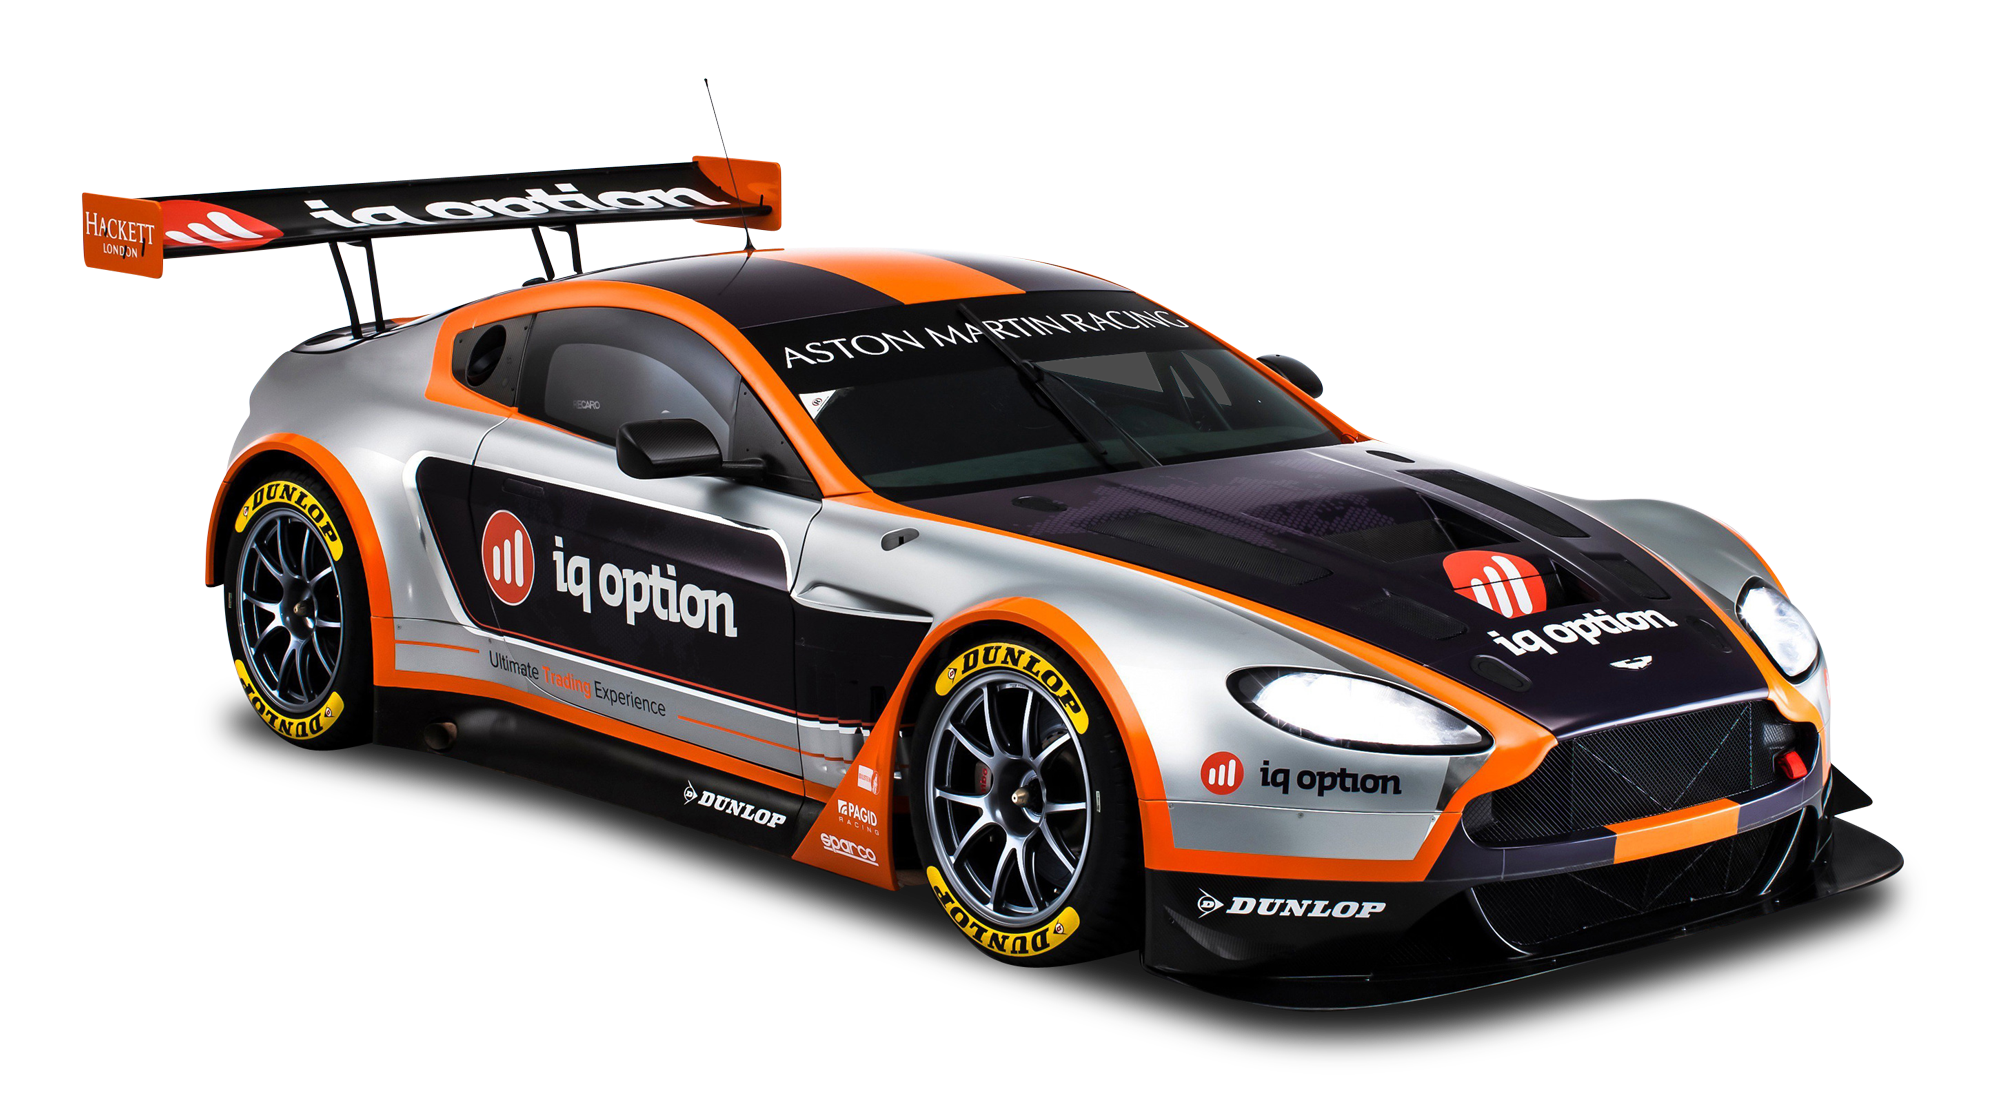

In [21]:
Image(filename= '../data/MobileNet_Sample/race-car-2000.png', width=600,height=400 )

In [23]:
preprocessed_image = prepare_image('race-car-2000.png')
predictions = mobile.predict(preprocessed_image)

In [24]:
imagenet_utils.decode_predictions(predictions)

[[('n04037443', 'racer', 0.9924189),
  ('n04285008', 'sports_car', 0.0068306825),
  ('n02974003', 'car_wheel', 0.0001786599),
  ('n03895866', 'passenger_car', 0.00016409098),
  ('n03127747', 'crash_helmet', 7.7404424e-05)]]

###  MobileNet Tuning to predict cat and dogs

In [25]:
train_path = "../data/dogs-vs-cats/train"
valid_path = "../data/dogs-vs-cats/valid"
test_path = "../data/dogs-vs-cats/test"

In [31]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input)\
                .flow_from_directory(train_path, target_size=(224,224),batch_size=10)

Found 82 images belonging to 2 classes.


In [32]:
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input)\
                .flow_from_directory(valid_path, target_size=(224,224),batch_size=10)

Found 20 images belonging to 2 classes.


In [34]:
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input)\
                .flow_from_directory(test_path, target_size=(224,224),batch_size=10,shuffle=False)

Found 24 images belonging to 2 classes.


In [35]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [44]:
# mobile.layers

#### We will modify and remove last 6 layers and train again

In [45]:
x = mobile.layers[-6].output # till - global_average_pooling2d 

In [46]:
output = Dense(units=2, activation='softmax')(x)

In [48]:
model = Model(inputs=mobile.input, outputs=output) # Created using functional API, not sequential

In [49]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128 

In [50]:
# Freezing all the layers except last five
for layer in model.layers[:-5]:
    layer.trainable = False

### Train the model

In [51]:
model.compile(optimizer=Adam(lr=0.001), loss="categorical_crossentropy", metrics=['accuracy'])

In [52]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=2)

Epoch 1/10
9/9 - 4s - loss: 0.3226 - accuracy: 0.8415 - val_loss: 8.7629 - val_accuracy: 0.5000
Epoch 2/10
9/9 - 4s - loss: 0.1778 - accuracy: 0.9756 - val_loss: 9.1196 - val_accuracy: 0.5000
Epoch 3/10
9/9 - 4s - loss: 0.0171 - accuracy: 0.9878 - val_loss: 6.0083 - val_accuracy: 0.5000
Epoch 4/10
9/9 - 3s - loss: 0.0517 - accuracy: 0.9878 - val_loss: 4.1730 - val_accuracy: 0.6000
Epoch 5/10
9/9 - 4s - loss: 0.1891 - accuracy: 0.9512 - val_loss: 3.3707 - val_accuracy: 0.6500
Epoch 6/10
9/9 - 4s - loss: 0.0116 - accuracy: 1.0000 - val_loss: 1.4792 - val_accuracy: 0.8000
Epoch 7/10
9/9 - 3s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.9144 - val_accuracy: 0.8500
Epoch 8/10
9/9 - 4s - loss: 0.0748 - accuracy: 0.9756 - val_loss: 0.9678 - val_accuracy: 0.8500
Epoch 9/10
9/9 - 4s - loss: 1.1101e-04 - accuracy: 1.0000 - val_loss: 1.0955 - val_accuracy: 0.8500
Epoch 10/10
9/9 - 3s - loss: 0.1444 - accuracy: 0.9512 - val_loss: 0.9885 - val_accuracy: 0.8500


In [53]:
test_labels = test_batches.classes
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1], dtype=int32)

In [55]:
test_batches.class_indices

{'cat': 0, 'dog': 1}

In [56]:
predictions = model.predict(x=test_batches, verbose=True)

3/3 [==============================] - 0s 116ms/step


In [57]:
predictions

array([[1.00000000e+00, 1.17848771e-08],
       [1.00000000e+00, 6.96099914e-11],
       [1.00000000e+00, 3.63393696e-13],
       [9.99999881e-01, 1.23178552e-07],
       [1.00000000e+00, 2.71904524e-18],
       [9.99998331e-01, 1.67868723e-06],
       [1.00000000e+00, 1.06933827e-14],
       [1.00000000e+00, 1.90526187e-14],
       [1.00000000e+00, 1.02493942e-11],
       [1.00000000e+00, 2.88342183e-10],
       [1.00000000e+00, 1.53565792e-15],
       [1.00000000e+00, 1.01264845e-08],
       [6.34541038e-06, 9.99993682e-01],
       [4.95372049e-04, 9.99504566e-01],
       [9.99477565e-01, 5.22419752e-04],
       [1.18539445e-09, 1.00000000e+00],
       [2.00411771e-11, 1.00000000e+00],
       [1.86066754e-05, 9.99981403e-01],
       [1.13318656e-02, 9.88668144e-01],
       [7.00968325e-01, 2.99031645e-01],
       [3.56265321e-12, 1.00000000e+00],
       [1.80901989e-05, 9.99981880e-01],
       [2.44362946e-06, 9.99997616e-01],
       [2.85280383e-10, 1.00000000e+00]], dtype=float32)

In [60]:
predictions.argmax(axis=1) # returns the indices which contains the max value

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1])

In [61]:
cm = confusion_matrix(y_true= test_labels , y_pred= predictions.argmax(axis=1))

In [68]:
def plot_confusion_matrix(cm, classes,
        normalize=False,
        title='Confusion matrix',
        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [73]:
cm_plot_labels = ['cat','dog']

Confusion matrix, without normalization
[[12  0]
 [ 2 10]]


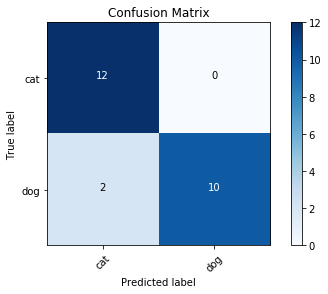

In [78]:
plot_confusion_matrix(cm, classes=list(test_batches.class_indices.keys()),title='Confusion Matrix')

### This worked pretty well also, the original mobile net was trained on classes of cats and dogs